In [9]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd; pd.set_option("display.max_columns", None)

import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import scipy
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import hierarchical_sampling_model
import util
import smoothing_spline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import allensdk
import h5py
import pynwb
import pandas
import hdmf
print('allensdk', allensdk.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('pandas', pandas.__version__)
print('hdmf', hdmf.__version__)

allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
pandas 1.1.1
hdmf 2.2.0


In [43]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [4]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

# Load data

### Neurons Selection

In [5]:
probes = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeA    78
probeD    78
probeB    57
probeF    47
Name: probe_description, dtype: int64

443

In [6]:
all_areas_map = session.map_probe_to_ecephys_structure_acronym(visual_only=False, verbose=True)
vis_areas_map = session.map_probe_to_ecephys_structure_acronym(visual_only=True, verbose=True)

----------- All recorded regions by probe ----------
probeA: ['APN' 'NOT' 'MB' 'DG' 'CA1' 'VISam']
probeB: ['LP' 'DG' 'CA1' 'VISam']
probeC: ['DG' 'ProS' 'SUB' 'VISp']
probeD: ['CA3' 'CA1' 'VISl']
probeE: ['LGv' 'CA3' 'CA2' 'CA1' 'VISal']
probeF: ['APN' 'TH' 'Eth' 'LP' 'CA3' 'DG' 'CA1' 'VISrl']
----------- Only visual ----------
probeA: ['VISam']
probeB: ['VISam']
probeC: ['VISp']
probeD: ['VISl']
probeE: ['VISal']
probeF: ['VISrl']


## Trials Selection

In [7]:
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
display(stimulus_table)

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1586.180717,2,drifting_gratings,1588.182387,15,2.00167,246
3799,0.8,180,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1589.183244,2,drifting_gratings,1591.184924,2,2.00168,247
3800,0.8,45,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1592.185737,2,drifting_gratings,1594.187427,1,2.00169,248
3801,0.8,90,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1595.188274,2,drifting_gratings,1597.189944,8,2.00167,249
3802,0.8,270,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1598.190777,2,drifting_gratings,1600.192447,2,2.00167,250
...,...,...,...,...,...,...,...,...,...,...,...,...
49428,0.8,315,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5384.355314,7,drifting_gratings,5386.356974,4,2.00166,260
49429,0.8,0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5387.357797,7,drifting_gratings,5389.359487,1,2.00169,252
49430,0.8,90,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5390.360334,7,drifting_gratings,5392.361994,8,2.00166,249


#### drifting gratings

In [118]:
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989
# condition_ids = [275, 268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x13 7989

In [8]:
condition_ids = [275, 268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x13 7989
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
hierarchical_sampling_model.HierarchicalSamplingModel.print_conditions(trials_groups)

0  249 temp freq [8.0] orient [90.0] contrast [0.8] [ 3801  3810  3828  3911  3964 31002 31054 31055 31178 49257 49317 49341 49365 49395 49430]
1  256 temp freq [15.0] orient [270.0] contrast [0.8] [ 3811  3845  3942  3958 31003 31056 31112 31126 31137 31169 31191 49260 49305 49344 49381]
2  257 temp freq [8.0] orient [315.0] contrast [0.8] [ 3813  3822  3870  3876  3932  3936  3987 31022 31027 31075 31171 49215 49217 49368 49370]
3  260 temp freq [4.0] orient [315.0] contrast [0.8] [ 3816  3888  3930  3943  3948 31028 31033 31190 49263 49266 49320 49364 49410 49411 49428]
4  261 temp freq [8.0] orient [135.0] contrast [0.8] [ 3817  3826  3875  3928 31020 31053 31129 31161 31162 49230 49254 49268 49275 49313 49407]
5  268 temp freq [4.0] orient [45.0] contrast [0.8] [ 3833  3882  3884  3899  3951  3988 31040 31086 31089 31116 31149 31197 49255 49277 49327]
6  270 temp freq [8.0] orient [45.0] contrast [0.8] [ 3835  3898  3914  3934 31062 31104 31114 49250 49274 49281 49286 49304 49322 

## Spike Trains

In [10]:
data_loader = data_model.AllenInstituteDataModel(session)
trial_time_window=[0.0, 2.0]
dt=0.0001
spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)

In [11]:
spike_trains = data_loader.get_trial_metric_per_unit_per_trial(
    stimulus_presentation_ids=all_trials_indices,
    unit_ids=selected_units.index.values,
    trial_time_window=trial_time_window,
    metric_type='spike_trains', dt=dt, verbose=True)
# spike_times = data_loader.get_trial_metric_per_unit_per_trial(
#         stimulus_presentation_ids=all_trials_indices,
#         unit_ids=selected_units.index.values,
#         trial_time_window=trial_time_window,
#         metric_type='spike_times')

neuron: 0
neuron: 40
neuron: 80
neuron: 120
neuron: 160
neuron: 200
neuron: 240
neuron: 280
neuron: 320
neuron: 360
neuron: 400
neuron: 440


In [14]:
spike_trains.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 443 entries, 951092050 to 951117155
Columns: 195 entries, 3801 to 49431
dtypes: object(195)
memory usage: 698.3+ KB


In [13]:
display(spike_trains.shape)
# display(spike_trains.head())
# display(spike_times.shape)
# display(spike_times.head())

(443, 195)

In [15]:
spike_trains

,3801,3810,3811,3813,3816,3817,3822,3826,3828,3833,3835,3844,3845,3855,3860,3862,3866,3870,3872,3875,3876,3878,3882,3884,3888,3889,3897,3898,3899,3900,3905,3911,3912,3914,3921,3924,3925,3928,3930,3932,3934,3936,3937,3938,3942,3943,3944,3946,3948,3951,3956,3958,3964,3980,3981,3984,3987,3988,3989,3995,3996,31002,31003,31004,31014,31020,31021,31022,31027,31028,31033,31034,31035,31040,31046,31047,31051,31053,31054,31055,31056,31058,31062,31064,31066,31071,31072,31075,31079,31080,31081,31085,31086,31089,31096,31104,31105,31112,31114,31116,31125,31126,31129,31133,31135,31137,31142,31148,31149,31156,31159,31161,31162,31166,31167,31169,31171,31172,31173,31174,31178,31179,31182,31184,31185,31188,31190,31191,31194,31197,31200,49211,49215,49217,49225,49230,49231,49247,49250,49254,49255,49257,49260,49263,49266,49268,49274,49275,49277,49281,49286,49290,49299,49301,49304,49305,49307,49313,49316,49317,49320,49322,49323,49327,49335,49341,49344,49349,49361,49364,49365,49367,49368,49370,49374,49380,49381,49389,49390,49394,49395,49399,49400,49401,49407,49410,49411,49415,49418,49420,49422,49427,49428,49430,49431
units,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951092050,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0

In [25]:
for trial_id in spike_trains.columns:
    output_path = f'C:/Users/Yu Chen/Downloads/spikes2/neuron_spikes_trial{trial_id}_mar17_2022.json'
    spike_trains[[trial_id]].to_json(output_path)
    break

In [29]:
spike_trains[[trial_id]]

,3801
units,
951092050,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951092075,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951092303,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951092398,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951092369,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
951117435,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951117571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951117127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [38]:
x = pd.read_json('C:/Users/Yu Chen/Downloads/spikes2/neuron_spikes_trial3801_mar17_2022.json',
                 convert_axes=False, convert_dates=False)

In [39]:
x

,3801
951092050,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951092075,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951092303,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951092369,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951092398,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
951117389,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951117418,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951117426,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
951117435,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Spiral dataset

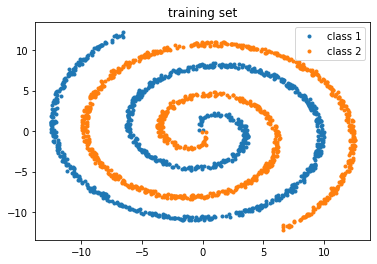

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def spirals(n_points, noise=.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

# Extract area-averaged data

In [18]:
import data_model
data_model = data_model.AllenInstituteDataModel(session)

In [19]:
data = data_model.extract_spike_trains_per_area(selected_units, spike_trains, trials_groups, spike_train_time_line, dt)

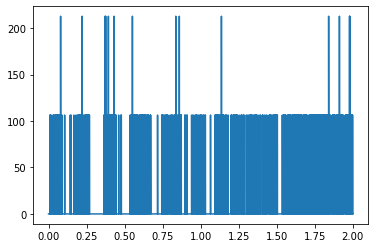

In [20]:
plt.plot(spike_train_time_line, data.iloc[78,2])

In [21]:
output_path = 'C:/Users/Yu Chen/Downloads/data_feb17_2022.pkl'
data.to_pickle(output_path)

In [22]:
output_path = 'C:/Users/Yu Chen/Downloads/data_feb17_2022.csv'
data.to_csv(output_path)

In [39]:
output_path = 'C:/Users/Yu Chen/Downloads/data_feb17_2022.json'
data.to_json(output_path)

In [40]:
# x = pd.read_pickle('C:/Users/Yu Chen/Downloads/data_feb17_2022.pkl')
# x = pd.read_csv('C:/Users/Yu Chen/Downloads/data_feb17_2022.csv')  # Doesn't work.
# x = pd.read_json('C:/Users/Yu Chen/Downloads/data_feb17_2022.json')
output_path = 'C:/Users/Yu Chen/Downloads/data_feb17_2022/data_feb17_2022.json'

spike_train_time_line = np.arange(0, 2, 0.0001)
x.head()
print(x.shape)

(195, 6)


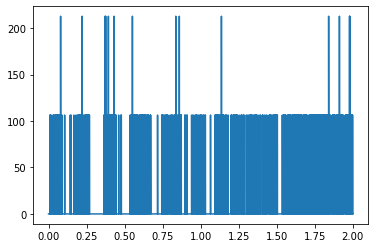

In [41]:
plt.plot(spike_train_time_line, x.iloc[78,2])